**<h5></h5>**
**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Fall 2024</center></h1>**
**<h1><center>Homework 3</center></h1>**
**<h1><center>Görkem Kadir Solun 22003214</center></h1>**
<h4><center>Due: December 29, 2024 23:59 (GMT+3)</center></h4>

## **CIFAR-10 Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train a convolutional neural network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 32x32 pixel resolution. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **22003214_GorkemKadir_Solun.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [İpek Öztaş](mailto:ipek.oztas@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns  # This not used
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print(
        "Total GPU Memory:",
        round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 1),
        "GB",
    )

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

**DO NOT CHANGE**<br>
To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. Please do not change these values.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-10 dataset is downloadable from [this link](https://drive.google.com/file/d/1KSKSWiBKvfxBpWmDmuRvUkn77YvWaIFW/view?usp=sharing). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [ ]:
# NOTE Change the data path to your data path
from google.colab import drive
print("Mounting Google Drive...")
print("Please have your data.zip ready on your Google Drive")
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/cifar10_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/1/919.png          
  inflating: test/1/976.png          
  inflating: test/1/9228.png         
  inflating: test/1/5217.png         
  inflating: test/1/260.png          
  inflating: test/1/5478.png         
  inflating: test/1/2212.png         
  inflating: test/1/6873.png         
  inflating: test/1/7939.png         
  inflating: test/1/8265.png         
  inflating: test/1/5560.png         
  inflating: test/1/110.png          
  inflating: test/1/4097.png         
  inflating: test/1/2521.png         
  inflating: test/1/5293.png         
  inflating: test/1/7928.png         
  inflating: test/1/2123.png         
  inflating: test/1/5962.png         
  inflating: test/1/129.png          
  inflating: test/1/3593.png         
  inflating: test/1/4124.png         
  inflating: test/1/2777.png         
  inflating: test/1/6132.png         
  inflating: test/1/1360.png         
  inflating: test/1/317.png          

### **Implementing a Custom Dataset [25 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads CIFAR-10 images from a dataset split folder. There are two split folders called train and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [ ]:
class CifarDataset(Dataset):
    """
    Custom dataset for the CIFAR-10 dataset

    Args:
        root_dir (str): The root directory of the dataset

    Returns:
        img (torch.Tensor): The image
        label (int): The label of the image
    """

    def __init__(self, root_dir):
        self.classes = sorted(os.listdir(root_dir))
        self.labels = []  # Store the labels of the images
        self.paths = []  # Store the path of the images
        self.transform = transforms.Compose(
            [
                # Resize the image to 32x32
                transforms.Resize((32, 32)),
                # Convert the image to a PyTorch tensor
                transforms.ToTensor(),
                # Normalize the images with mean and std of the dataset (-1, 1)
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        for i, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.labels.append(i)
                self.paths.append(os.path.join(cls_path, img_name))

        self.labels = sorted(self.labels)
        self.paths = sorted(self.paths)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, data_id):
        img = Image.open(self.paths[data_id])
        img = img.convert("RGB")
        img = self.transform(img)
        # label = self.labels[data_id]
        return img

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [ ]:
train_dataset = CifarDataset("/content/train")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CifarDataset("/content/test")
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of CIFAR-10 images properly.

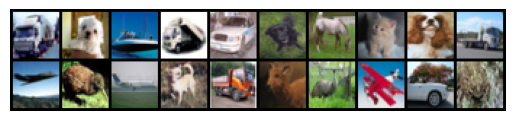

In [ ]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader))  # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis("off")
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.

In [ ]:
class CifarAutoencoder(nn.Module):
    """
    The (in_channel, out_channel) pairs of the layers should be defined as follows:

    **Encoder:**
    - (3, 16)
    - (16, 32)
    - (32, 64)

    **Decoder:**
    - (64, 32)
    - (32, 16)
    - (16, 3)

    You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

    In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.
    """

    def __init__(self):
        super(CifarAutoencoder, self).__init__()

        # The input size of the encoder should be 3x32x32
        # The output size of the encoder is 64x2x2
        self.encoder = nn.Sequential(
            # Define the encoder layers
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 32x32
            nn.BatchNorm2d(16),  # 32x32
            nn.LeakyReLU(0.2),  # 32x32
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 16x16
            nn.BatchNorm2d(32),  # 8x8
            nn.LeakyReLU(0.2),  # 8x8
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 8x8
            nn.BatchNorm2d(64),  # 4x4
            nn.LeakyReLU(0.2),  # 4x4
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4
        )

        # The output size of the encoder is 64x2x2
        # The input size of the decoder should be 64x2x2
        self.decoder = nn.Sequential(
            # Define the decoder layers
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 8x8
            nn.BatchNorm2d(32),  # 8x8
            nn.LeakyReLU(0.2),  # 8x8
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 16x16
            nn.BatchNorm2d(16),  # 16x16
            nn.LeakyReLU(0.2),  # 16x16
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # 32x32
            nn.Tanh(),  # 32x32
        )

        print("Autoencoder created successfully")

    def forward(self, x):
        # The forward pass of the network
        return self.decoder(self.encoder(x))

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [ ]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    """
    Train the model with the given parameters

    Args:
        model (nn.Module): The model to be trained
        train_dataloader (DataLoader): The dataloader for the training dataset
        optimizer (torch.optim): The optimizer to be used
        loss_func (torch.nn): The loss function to be used
        num_epochs (int): The number of epochs to train the model

    Returns:
        epoch_losses (list): The loss value for each epoch
    """

    model.train()  # Set the model to training mode
    model = model.to(device)
    epoch_losses = []  # Store the loss value for each epoch
    print("Training the model...")

    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Store the loss value for each epoch
        model = model.to(device)

        for images in tqdm(train_dataloader):
            images = images.to(device)
            # Mask the images by setting the second half of the pixels to -1
            masked_images = images.clone()
            masked_images[:, :, :, 16:32] = -1

            # Forward pass and calculate the loss
            outputs = model(masked_images)
            loss = loss_func(outputs, images)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate the mean loss for the epoch
        epoch_loss /= len(train_dataloader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print("Finished training.")
    return epoch_losses

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [ ]:
def evaluate_model(model, test_dataloader):
    """
    Evaluate the model with the given parameters

    Args:
        model (nn.Module): The model to be evaluated
        test_dataloader (DataLoader): The dataloader for the test dataset

    Returns:
        mean_loss (float): The mean loss of the test dataset
    """

    total_loss = 0.0 # Store the total loss of the test dataset
    num_images = 0 # Store the number of images in the test dataset
    model = model.to(device)
    print("Evaluating the model...")

    with torch.no_grad():
        for images in tqdm(test_dataloader):
            images = images.to(device)
            # Mask the images by setting the second half of the pixels to -1
            masked_images = images.clone()
            masked_images[:, :, :, 16:32] = -1

            outputs = model(masked_images)  # Get the output from the model
            print(outputs.shape)
            print(images.shape)
            loss = nn.MSELoss(reduction="mean")(
                outputs, images
            )  # Calculate the MSE loss

            total_loss += loss.item()
            num_images += len(images)

    # Return the mean loss of the test dataset
    print("Finished evaluation.")
    return total_loss / num_images

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. **Do not change the codes in the cell**.

In [ ]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader))  # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
        masked_images = images.clone()
        masked_images[:, :, :, 16:] = -1
        inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis("off")
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the mean square error that your model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



Autoencoder created successfully
Training the model...


100%|██████████| 782/782 [00:34<00:00, 22.54it/s]


Epoch 1/50, Loss: 0.1605


100%|██████████| 782/782 [00:31<00:00, 24.76it/s]


Epoch 2/50, Loss: 0.1180


100%|██████████| 782/782 [00:31<00:00, 24.80it/s]


Epoch 3/50, Loss: 0.1137


100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


Epoch 4/50, Loss: 0.1110


100%|██████████| 782/782 [00:31<00:00, 24.63it/s]


Epoch 5/50, Loss: 0.1091


100%|██████████| 782/782 [00:31<00:00, 24.79it/s]


Epoch 6/50, Loss: 0.1079


100%|██████████| 782/782 [00:31<00:00, 24.63it/s]


Epoch 7/50, Loss: 0.1070


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Epoch 8/50, Loss: 0.1063


100%|██████████| 782/782 [00:31<00:00, 24.96it/s]


Epoch 9/50, Loss: 0.1058


100%|██████████| 782/782 [00:31<00:00, 24.89it/s]


Epoch 10/50, Loss: 0.1054


100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


Epoch 11/50, Loss: 0.1050


100%|██████████| 782/782 [00:31<00:00, 25.10it/s]


Epoch 12/50, Loss: 0.1046


100%|██████████| 782/782 [00:31<00:00, 24.93it/s]


Epoch 13/50, Loss: 0.1043


100%|██████████| 782/782 [00:31<00:00, 24.56it/s]


Epoch 14/50, Loss: 0.1040


100%|██████████| 782/782 [00:31<00:00, 24.82it/s]


Epoch 15/50, Loss: 0.1038


100%|██████████| 782/782 [00:31<00:00, 24.81it/s]


Epoch 16/50, Loss: 0.1035


100%|██████████| 782/782 [00:31<00:00, 24.76it/s]


Epoch 17/50, Loss: 0.1033


100%|██████████| 782/782 [00:31<00:00, 24.52it/s]


Epoch 18/50, Loss: 0.1031


100%|██████████| 782/782 [00:31<00:00, 24.71it/s]


Epoch 19/50, Loss: 0.1029


100%|██████████| 782/782 [00:31<00:00, 24.84it/s]


Epoch 20/50, Loss: 0.1027


100%|██████████| 782/782 [00:32<00:00, 24.39it/s]


Epoch 21/50, Loss: 0.1026


100%|██████████| 782/782 [00:31<00:00, 25.16it/s]


Epoch 22/50, Loss: 0.1025


100%|██████████| 782/782 [00:31<00:00, 25.18it/s]


Epoch 23/50, Loss: 0.1023


100%|██████████| 782/782 [00:31<00:00, 24.46it/s]


Epoch 24/50, Loss: 0.1022


100%|██████████| 782/782 [00:31<00:00, 25.08it/s]


Epoch 25/50, Loss: 0.1021


100%|██████████| 782/782 [00:31<00:00, 24.50it/s]


Epoch 26/50, Loss: 0.1020


100%|██████████| 782/782 [00:31<00:00, 24.68it/s]


Epoch 27/50, Loss: 0.1019


100%|██████████| 782/782 [00:31<00:00, 24.56it/s]


Epoch 28/50, Loss: 0.1018


100%|██████████| 782/782 [00:31<00:00, 24.79it/s]


Epoch 29/50, Loss: 0.1017


100%|██████████| 782/782 [00:31<00:00, 24.80it/s]


Epoch 30/50, Loss: 0.1016


100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


Epoch 31/50, Loss: 0.1016


100%|██████████| 782/782 [00:31<00:00, 24.97it/s]


Epoch 32/50, Loss: 0.1015


100%|██████████| 782/782 [00:31<00:00, 25.00it/s]


Epoch 33/50, Loss: 0.1014


100%|██████████| 782/782 [00:32<00:00, 24.24it/s]


Epoch 34/50, Loss: 0.1013


100%|██████████| 782/782 [00:31<00:00, 24.78it/s]


Epoch 35/50, Loss: 0.1012


100%|██████████| 782/782 [00:32<00:00, 24.05it/s]


Epoch 36/50, Loss: 0.1011


100%|██████████| 782/782 [00:34<00:00, 22.54it/s]


Epoch 37/50, Loss: 0.1011


100%|██████████| 782/782 [00:34<00:00, 22.95it/s]


Epoch 38/50, Loss: 0.1010


100%|██████████| 782/782 [00:34<00:00, 22.66it/s]


Epoch 39/50, Loss: 0.1010


100%|██████████| 782/782 [00:34<00:00, 22.68it/s]


Epoch 40/50, Loss: 0.1009


100%|██████████| 782/782 [00:33<00:00, 23.24it/s]


Epoch 41/50, Loss: 0.1009


100%|██████████| 782/782 [00:33<00:00, 23.57it/s]


Epoch 42/50, Loss: 0.1008


100%|██████████| 782/782 [00:31<00:00, 24.58it/s]


Epoch 43/50, Loss: 0.1007


100%|██████████| 782/782 [00:32<00:00, 24.24it/s]


Epoch 44/50, Loss: 0.1007


100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Epoch 45/50, Loss: 0.1007


100%|██████████| 782/782 [00:31<00:00, 24.65it/s]


Epoch 46/50, Loss: 0.1006


100%|██████████| 782/782 [00:32<00:00, 23.91it/s]


Epoch 47/50, Loss: 0.1006


100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch 48/50, Loss: 0.1006


100%|██████████| 782/782 [00:31<00:00, 24.63it/s]


Epoch 49/50, Loss: 0.1005


100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


Epoch 50/50, Loss: 0.1005
Finished training.


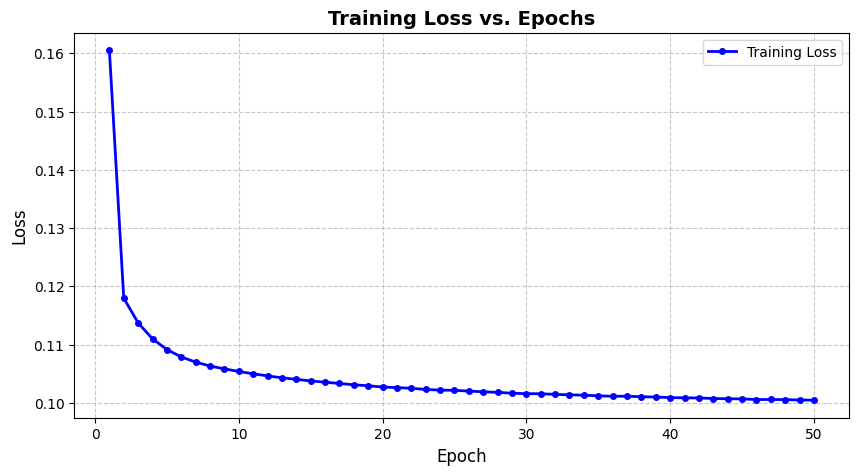

Evaluating the model...


  5%|▌         | 1/20 [00:00<00:05,  3.69it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 10%|█         | 2/20 [00:00<00:04,  3.78it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 15%|█▌        | 3/20 [00:00<00:04,  3.78it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 20%|██        | 4/20 [00:01<00:04,  3.70it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 25%|██▌       | 5/20 [00:01<00:03,  3.77it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 30%|███       | 6/20 [00:01<00:03,  3.81it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 35%|███▌      | 7/20 [00:01<00:03,  3.82it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 40%|████      | 8/20 [00:02<00:03,  3.73it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 45%|████▌     | 9/20 [00:02<00:02,  3.78it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 50%|█████     | 10/20 [00:02<00:02,  3.77it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 55%|█████▌    | 11/20 [00:02<00:02,  3.78it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 60%|██████    | 12/20 [00:03<00:02,  3.77it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 65%|██████▌   | 13/20 [00:03<00:01,  3.80it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 70%|███████   | 14/20 [00:03<00:01,  3.82it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 75%|███████▌  | 15/20 [00:03<00:01,  3.80it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 80%|████████  | 16/20 [00:04<00:01,  3.79it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 85%|████████▌ | 17/20 [00:04<00:00,  3.81it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


 90%|█████████ | 18/20 [00:04<00:00,  3.81it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([272, 3, 32, 32])
torch.Size([272, 3, 32, 32])
Finished evaluation.
Test MSE: 0.00021097524687647818


In [ ]:
seed_everything(464)
model = CifarAutoencoder()  # Create the model
model = model.to(device)

train_losses = train_model(
    model,
    train_dataloader,
    optim.Adam(model.parameters(), lr=2e-4),
    nn.MSELoss(reduction="mean"),
    50,
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), train_losses, color="blue", linewidth=2, marker="o", markersize=4, label="Training Loss")
plt.title("Training Loss vs. Epochs", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

print(f"Test MSE: {evaluate_model(model, test_dataloader)}")

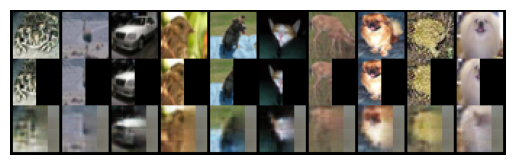

In [ ]:
visualize_inpainting(model, test_dataset)